# Case Study 2 : Data Science in Financial Data

**Recommended Readings:** 
* [Quantopian Tutorials](https://www.quantopian.com/tutorials/) 
* Please register an account in [Quantopian online notebook system](https://www.quantopian.com/notebooks/).
* Upload this file into the system and start working on your idea.


**NOTE**
* Please download your code (notebook file as an ipynb file) and include it in your submission.


# Problem: pick a data science problem that you plan to solve using Stock Price Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data available and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

# Data Collection/Processing: 

## Grab the data

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import statsmodels
from __future__ import print_function

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import EquityPricing
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.research import prices
from quantopian.pipeline.data.morningstar import Fundamentals
from quantopian.pipeline.data.factset import Fundamentals as fd
#from quantopian.pipeline.data.factset import Fundamentals as fact

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoLarsCV, LassoCV

import re
from itertools import product

In [2]:
period_start = '2018-10-8'
period_end = '2019-10-11'
def make_pipeline():
    returns = Returns(window_length=2)
    sentiment = stocktwits.bull_minus_bear.latest
    msg_volume = stocktwits.total_scanned_messages.latest
    high = EquityPricing.high.latest
    low = EquityPricing.low.latest
    close_price = EquityPricing.open.latest
    volume = EquityPricing.volume.latest  # Number of shares traded
    total_revenue =  Fundamentals.total_revenue.latest
    share_issued = Fundamentals.share_issued.latest
    #price_earnings = fact.pe_cf.latest
    return Pipeline(
        columns={
            'daily_returns': returns,
            'sentiment': sentiment,
            'msg_volume': msg_volume,
            'high': high,
            'low': low,
            'close': close_price,
            'volume':volume,
            'total_revenue': total_revenue,
            #'share_issued': share_issued
            
        },
    )

# Pipeline execution
data_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)


Process the column names, and convert symbols to strings.

In [3]:
data_output.reset_index(inplace=True)
data_output.rename(columns={'level_0':'date', 'level_1':'symbols'}, inplace=True)
data_output['symbols'] = data_output['symbols'].apply(str)

In [4]:
data_output.head()

,date,symbols,close,daily_returns,high,low,msg_volume,sentiment,total_revenue,volume
0,2018-10-08 00:00:00+00:00,Equity(2 [ARNC]),22.160,-0.016888,22.43,21.77,3.0,0.470000,3.573000e+09,2929952.0
1,2018-10-08 00:00:00+00:00,Equity(21 [AAME]),NaN,NaN,NaN,NaN,1.0,0.000000,4.944300e+07,0.0
2,2018-10-08 00:00:00+00:00,Equity(24 [AAPL]),227.960,-0.016977,228.41,220.58,221.0,-0.623655,5.326500e+10,25805820.0
3,2018-10-08 00:00:00+00:00,Equity(25 [ARNC_PR]),83.993,NaN,84.75,83.75,NaN,NaN,5.295000e+09,662.0
4,2018-10-08 00:00:00+00:00,Equity(41 [ARCB]),45.140,-0.115377,45.96,41.23,2.0,-2.890000,7.933500e+08,570535.0


In [5]:
print('the shape of the output date is (%d, %d)' % data_output.shape)

the shape of the output date is (2231564, 10)


## deal with nulls

In [6]:
print('Missing value percentage')
data_output.isnull().sum() / data_output.shape[0]

Missing value percentage


date             0.000000
symbols          0.000000
close            0.064169
daily_returns    0.088956
high             0.064168
low              0.064170
msg_volume       0.256864
sentiment        0.256864
total_revenue    0.417428
volume           0.000000
dtype: float64

Drop total_revenue with 40% missing values

In [7]:
data_output.drop(['total_revenue'], axis=1, inplace=True)

In [8]:
print('Missing value percentage')
data_output.isnull().sum() / data_output.shape[0]

Missing value percentage


date             0.000000
symbols          0.000000
close            0.064169
daily_returns    0.088956
high             0.064168
low              0.064170
msg_volume       0.256864
sentiment        0.256864
volume           0.000000
dtype: float64

In [9]:
print('Number of equities is %d' % pd.unique(data_output['symbols']).shape[0])

Number of equities is 9599


In [10]:
data_output.head()

,date,symbols,close,daily_returns,high,low,msg_volume,sentiment,volume
0,2018-10-08 00:00:00+00:00,Equity(2 [ARNC]),22.160,-0.016888,22.43,21.77,3.0,0.470000,2929952.0
1,2018-10-08 00:00:00+00:00,Equity(21 [AAME]),NaN,NaN,NaN,NaN,1.0,0.000000,0.0
2,2018-10-08 00:00:00+00:00,Equity(24 [AAPL]),227.960,-0.016977,228.41,220.58,221.0,-0.623655,25805820.0
3,2018-10-08 00:00:00+00:00,Equity(25 [ARNC_PR]),83.993,NaN,84.75,83.75,NaN,NaN,662.0
4,2018-10-08 00:00:00+00:00,Equity(41 [ARCB]),45.140,-0.115377,45.96,41.23,2.0,-2.890000,570535.0


## Choose equities

In [11]:
## Lowest Total Debt % Total Assets
debt_assets_af = fd.debt_assets_af.latest
pipe = Pipeline(
    columns={
        'debt_assets_af': debt_assets_af,
    },    
)
df_assets_af = run_pipeline(pipe, '2017-10-05', '2018-10-24')
df_assets_af.reset_index(inplace=True)
df_assets_af.rename(columns={'level_0':'date', 'level_1':'symbols'}, inplace=True)
df_assets_af=df_assets_af.dropna(subset=['debt_assets_af'])
a=df_assets_af.sort_values(by=['debt_assets_af'],ascending=True).symbols.unique()

In [12]:
## Lowest P/E ratio
pe_ratio=Fundamentals.pe_ratio.latest
pipe = Pipeline(
    columns={
        'pe_ratio': pe_ratio,
    },    
)
df_pe_ratio = run_pipeline(pipe, period_end, period_end)
df_pe_ratio.reset_index(inplace=True)
df_pe_ratio.rename(columns={'level_0':'date', 'level_1':'symbols'}, inplace=True)
df_pe_ratio=df_pe_ratio.dropna(subset=['pe_ratio'])
b=df_pe_ratio.sort_values(by=['pe_ratio'],ascending=True).symbols.unique()

In [13]:
num=100
ret1= [x for x in a[:num] if x in set(b[:num])]
ret1

[Equity(43025 [LPCN]), Equity(8732 [SCON])]

In [14]:
equities = list(map(str, ret1))

## make X and Y

We use all the extracted feature in time T-LAG to T-1 as X, and the close price of T as Y. LAG is a hyper-parameter to tune. 

Hyper-parameters to tune:

In [15]:
LAG = 2
NA = 'inter'
#NA = 'average'
#NA = 'drop'

LAGS_REDUCE = 'ravel'
#LAGS_REDUCE = 'average'

In [16]:
start_t = data_output['date'].min()
end_t = data_output['date'].max()
print('start datetime is\n%s' % start_t)
print('end datetime is\n%s' % end_t)

start datetime is
2018-10-08 00:00:00+00:00
end datetime is
2019-10-11 00:00:00+00:00


Function to deal with one equity

In [17]:
def deal_with_one_equity(df, deal_na=NA, lag_reduce=LAGS_REDUCE):
    drop = 0
    X = []
    Y = []
    time_list = []
    this_df = df.drop(['symbols', 'date'], axis=1).reset_index(drop=True)
    days_diff = this_df.shape[0]
    
    # deal with NAs
    
    if deal_na == 'inter':
        this_df = this_df.fillna(method='ffill').fillna(method='bfill')
    elif deal_na == 'average':
        this_df = this_df.fillna(this_df.mean())
    elif deal_na == 'drop':
        # DO NOT USE THIS!!!!!
        raise ValueError('Tested feature')
        this_df = this_df.drop(this_df.isnull())
    
    for time in range(LAG, days_diff):
        X_time = [time - i for i in range(1, LAG + 1)]
        Y_time = time
        
        df_x = this_df.loc[X_time]
        df_y = this_df['close'].loc[Y_time]
        
        # reduce X
        if lag_reduce == 'ravel':
            new_df_x =[]
            for i, index in df_x.iterrows():
                new_df_x.extend(index.tolist())
            new_df_x = pd.DataFrame(new_df_x).T
            new_df_x.columns = [str(item) + '_lag%s' % i for i in range(1, LAG + 1) for item in df_x.columns]
            new_df_x['time'] = time
            new_df_x.set_index('time', drop=True, inplace=True)
            df_x = new_df_x
        X.append(df_x)
        Y.append(df_y)
        time_list.append(time)
    df_X = pd.concat(X, axis=0)
    df_Y = pd.DataFrame(Y, index=time_list, columns=['close'])
    return df_X, df_Y, time_list, drop

Use the above function to process selected equities

In [18]:
Xs = {}
Ys = {}
for equity in equities:
    X, Y, _, drop = deal_with_one_equity(data_output[data_output['symbols'] == equity])
    Xs[equity] = X
    Ys[equity] = Y
    print('for equity %s, %d days are droped because of missing values' % (equity, drop))

for equity Equity(43025 [LPCN]), 0 days are droped because of missing values
for equity Equity(8732 [SCON]), 0 days are droped because of missing values


Preporcessing results

Xs = {equity name: X}

Ys = {equity name: Y}

equities = \[equity name\]

In [19]:
print('X is like')
Xs[equities[0]].head()

X is like


,close_lag1,daily_returns_lag1,high_lag1,low_lag1,msg_volume_lag1,sentiment_lag1,volume_lag1,close_lag2,daily_returns_lag2,high_lag2,low_lag2,msg_volume_lag2,sentiment_lag2,volume_lag2
time,,,,,,,,,,,,,,
2,1.36,-0.011070,1.37,1.31,2.0,0.000,36113.0,1.33,0.003704,1.38,1.33,1.0,-1.770,15360.0
3,1.33,0.007463,1.36,1.31,3.0,0.000,11206.0,1.36,-0.011070,1.37,1.31,2.0,0.000,36113.0
4,1.34,-0.014815,1.36,1.31,6.0,-1.105,44501.0,1.33,0.007463,1.36,1.31,3.0,0.000,11206.0
5,1.34,-0.015038,1.34,1.30,9.0,0.000,15253.0,1.34,-0.014815,1.36,1.31,6.0,-1.105,44501.0
6,1.33,0.030534,1.35,1.31,5.0,1.380,40725.0,1.34,-0.015038,1.34,1.30,9.0,0.000,15253.0


In [20]:
print('Y is like')
Ys[equities[0]].head()

Y is like


,close
2,1.33
3,1.34
4,1.34
5,1.33
6,1.35


# Data Exploration: Exploring the Dataset

**plot the weekly returns of a set of stocks of your choice** 


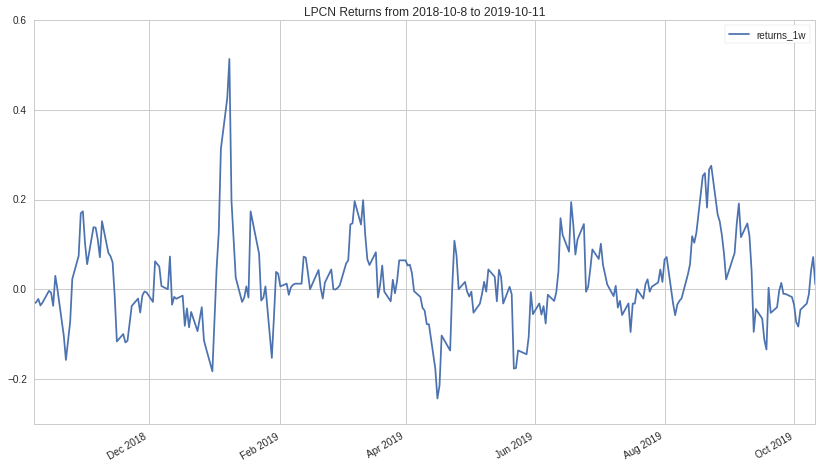

In [21]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

pipe = Pipeline(
    columns={
        #'returns_1d': Returns(window_length=2),
        'returns_1w': Returns(window_length=6),
        #'returns_1m': Returns(window_length=22),
    },
)

data = run_pipeline(pipe, period_start, period_end)

LPCN_data = data.xs(symbols('LPCN'), level=1)

LPCN_data.plot(title='LPCN Returns from ' + period_start + ' to ' + period_end);


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe95a581610>]], dtype=object)

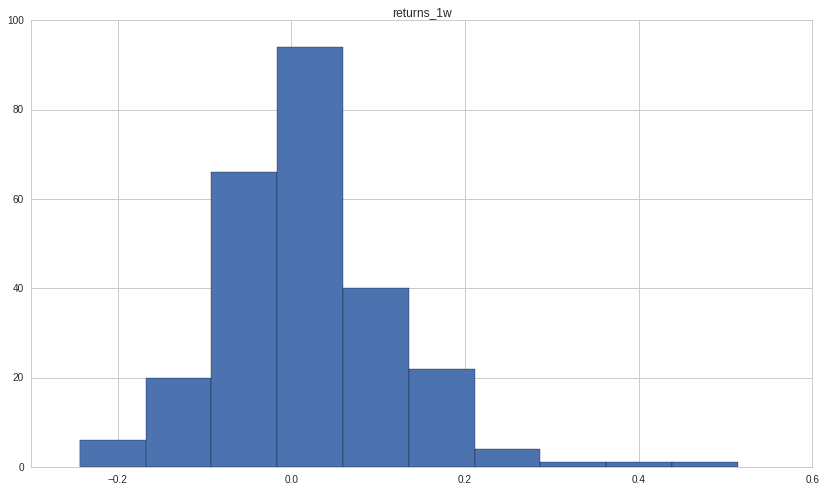

In [22]:
LPCN_data.hist()

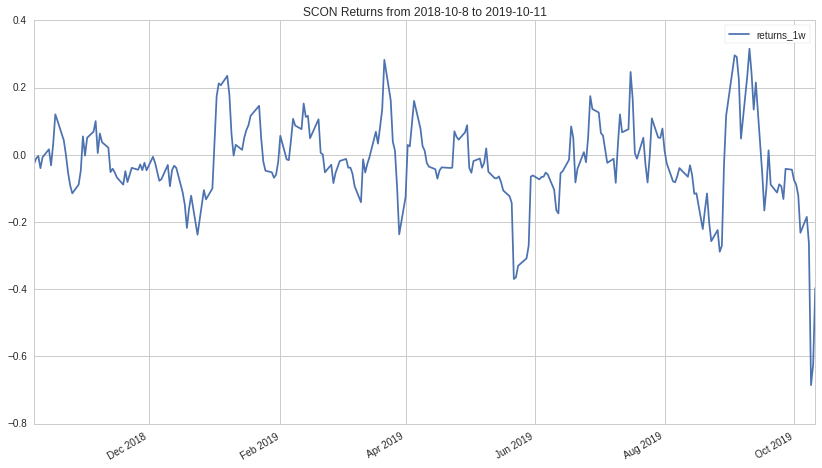

In [23]:
pipe = Pipeline(
    columns={
        #'returns_1d': Returns(window_length=2),
        'returns_1w': Returns(window_length=6),
        #'returns_1m': Returns(window_length=22),
    },
)

data = run_pipeline(pipe, period_start, period_end)

SCON_data = data.xs(symbols('SCON'), level=1)

SCON_data.plot(title='SCON Returns from ' + period_start + ' to ' + period_end);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe95afd50d0>]], dtype=object)

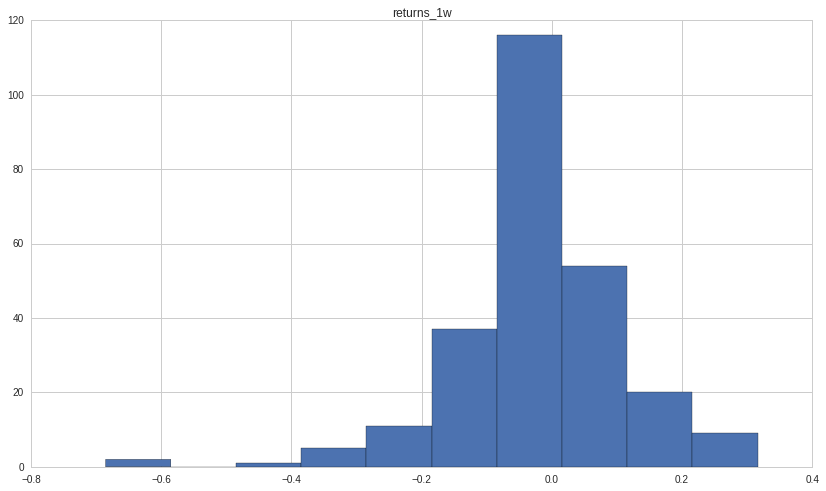

In [24]:
SCON_data.hist()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

We choose price information (open, close, daily high and low price) and message and sentiment indicators (message volume, sentiment (bull-bear)) with lag n = 2 as our features. 
Perform least square and Lasso regression. Use the first 70% of our time range for training, last 30% for testing.

Write codes to implement the solution in python:

train test split

In [25]:
Xs.keys()

['Equity(8732 [SCON])', 'Equity(43025 [LPCN])']

In [26]:
equity = 'Equity(43025 [LPCN])'
X = Xs[equity]
Y = Ys[equity]

In [27]:
l = X.shape[0]
X_train = X.iloc[0:int(0.7 * l)]
Y_train = Y.iloc[0:int(0.7 * l)]
X_test = X.iloc[int(0.7 * l):]
Y_test = Y.iloc[int(0.7 * l):]

## Do the regression

In [28]:
est = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print(est.summary())
print()
print("R-squareds:", est.rsquared)
print("Prob (F-statistic):", est.f_pvalue)
#print('Not significant features:')
#for i in est.pvalues.index:
#    if est.pvalues[i] > 0.05:
#        print(i)

Y_train_pred = est.predict(sm.add_constant(X_train))
Y_test_pred = est.predict(sm.add_constant(X_test))

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     206.1
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           2.13e-95
Time:                        20:47:36   Log-Likelihood:                 220.41
No. Observations:                 177   AIC:                            -410.8
Df Residuals:                     162   BIC:                            -363.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                 -0.0270      0

See the metrics and figures

In [29]:
mse_train = mean_squared_error(Y_train_pred, Y_train)
mse_test = mean_squared_error(Y_test_pred, Y_test)
mae_train = mean_absolute_error(Y_train_pred, Y_train)
mae_test = mean_absolute_error(Y_test_pred, Y_test)

print('mse_train: ', mse_train)
print('mse_test: ', mse_test)
print('mae_train: ', mae_train)
print('mae_test: ', mae_test)
print('rmse_train: ', np.sqrt(mse_train))
print('rmse_test: ', np.sqrt(mse_test))

mse_train:  0.00485189215694
mse_test:  0.00236111138368
mae_train:  0.0323576018319
mae_test:  0.0359383107084
rmse_train:  0.0696555249563
rmse_test:  0.0485912685951


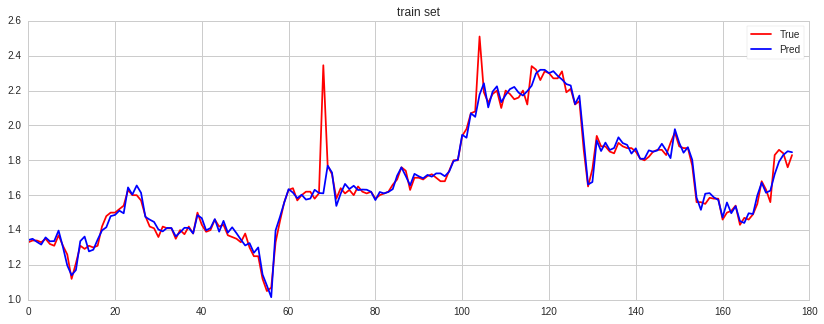

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


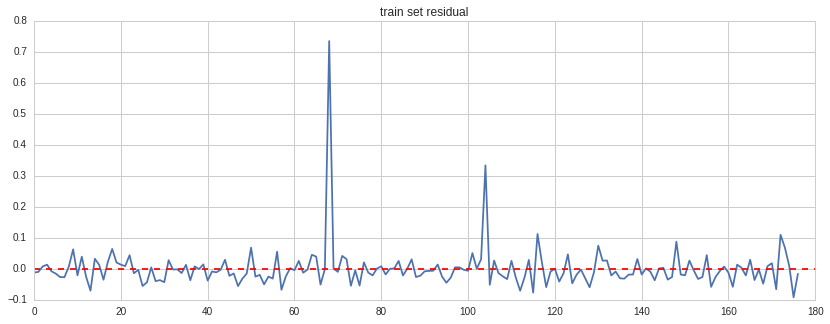

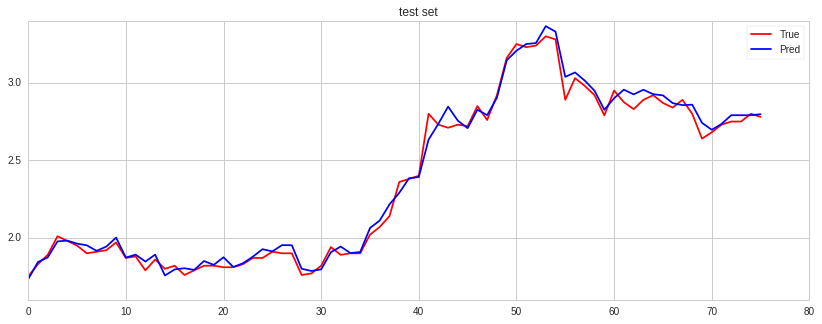

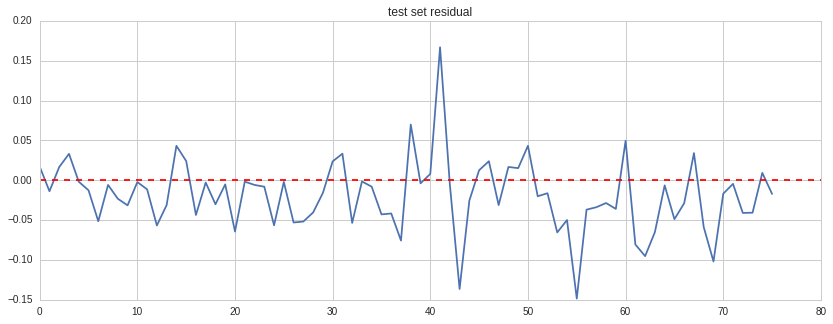

In [30]:
plt.figure(figsize=(14,5))
plt.plot(Y_train.values, c='r', label='True')
plt.plot(Y_train_pred, c='b', label='Pred')
plt.title('train set')
plt.legend()
plt.show()

train_res = Y_train.values.reshape(-1,) - Y_train_pred
plt.figure(figsize=(14,5))
plt.plot(train_res)
plt.axhline(0, ls='--', c='r')
plt.title('train set residual')
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(Y_test.values, c='r', label='True')
plt.plot(Y_test_pred, c='b', label='Pred')
plt.title('test set')
plt.legend()
plt.show()

test_res = Y_test.values.reshape(-1,) - Y_test_pred
plt.figure(figsize=(14,5))
plt.plot(test_res)
plt.axhline(0, ls='--', c='r')
plt.title('test set residual')
plt.legend()
plt.show()

In [31]:
Y_train_pred.shape

(177,)

We can see that there is strong multicollinearity in the data. This is because that the date of the feature is close and natually they have multicollinearity. 

To deal with this problem, we can calculate the difference sequence and use these as features.

## Differentiate the feature sequence

In [32]:
# grab the name of features and the max lag order
def diff(X):
    column_pat = r'(.+)_lag(\d+)'

    def name_on_feat_lag(name, lag):
        return '%s_lag%d' % (name, lag)

    def name_on_feat_diff(name, diff):
        return '%s_diff%d' % (name, diff)

    features_name = []
    lags = []

    for col_name in X.columns:
        m = re.match(column_pat, col_name)
        feature_name, lag = m.groups()
        features_name.append(feature_name)
        lags.append(int(lag))

    max_lag = max(lags)

    # create new X
    X_diff = X.copy()

    for lag, col_name in product(range(2, max_lag + 1), features_name):
        X_diff[name_on_feat_diff(col_name, lag)] = \
            X[name_on_feat_lag(col_name, lag)] - X[name_on_feat_lag(col_name, lag - 1)]
        try:
            X_diff.drop([name_on_feat_lag(col_name, lag)], axis=1, inplace=True)
        except:
            pass
    return X_diff


X_diff = diff(X)

redo the regression

In [33]:
X_train = X_diff.iloc[0:int(0.7 * l)]
Y_train = Y.iloc[0:int(0.7 * l)]
X_test = X_diff.iloc[int(0.7 * l):]
Y_test = Y.iloc[int(0.7 * l):]

In [34]:
est = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print(est.summary())
print()
print("R-squareds:", est.rsquared)
print("Prob (F-statistic):", est.f_pvalue)
#print('Not significant features:')
#for i in est.pvalues.index:
#    if est.pvalues[i] > 0.05:
#        print(i)

Y_train_pred = est.predict(sm.add_constant(X_train))
Y_test_pred = est.predict(sm.add_constant(X_test))

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     206.1
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           2.13e-95
Time:                        20:47:37   Log-Likelihood:                 220.41
No. Observations:                 177   AIC:                            -410.8
Df Residuals:                     162   BIC:                            -363.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  -0.0270    

Still have multicollinearity. Try LASSO regression for a automatic feature selection

## LASSO

In [35]:
las = LassoLarsCV(cv=5).fit(X_train, Y_train.values.reshape(-1,))
Y_train_pred = las.predict(X_train)
Y_test_pred = las.predict(X_test)
print('Train R^2:%f' % las.score(X_train, Y_train))

Train R^2:0.946783


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=1.814e-04, previous alpha=9.287e-06, with an active set of 13 regressors.
  ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


In [36]:
mse_train = mean_squared_error(Y_train_pred, Y_train)
mse_test = mean_squared_error(Y_test_pred, Y_test)
mae_train = mean_absolute_error(Y_train_pred, Y_train)
mae_test = mean_absolute_error(Y_test_pred, Y_test)

print('mse_train: ', mse_train)
print('mse_test: ', mse_test)
print('mae_train: ', mae_train)
print('mae_test: ', mae_test)
print('rmse_train: ', np.sqrt(mse_train))
print('rmse_test: ', np.sqrt(mse_test))

mse_train:  0.00485794112721
mse_test:  0.00237538369327
mae_train:  0.0323552753514
mae_test:  0.0362140412845
rmse_train:  0.0696989320378
rmse_test:  0.048737908175


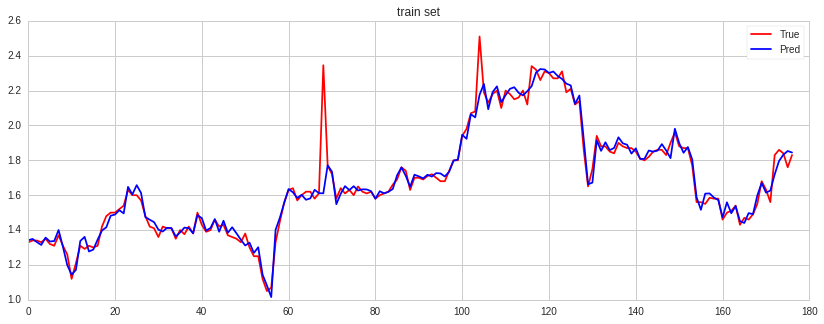

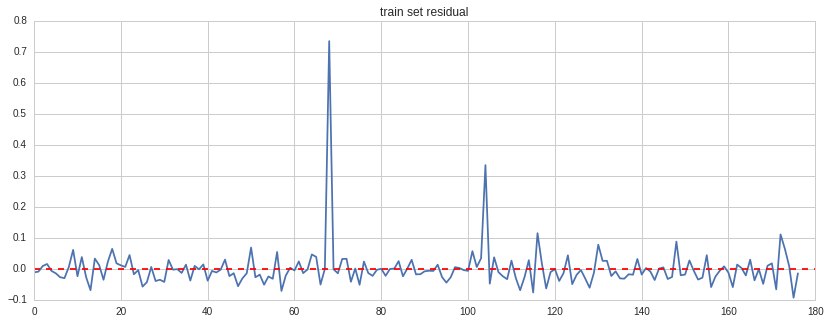

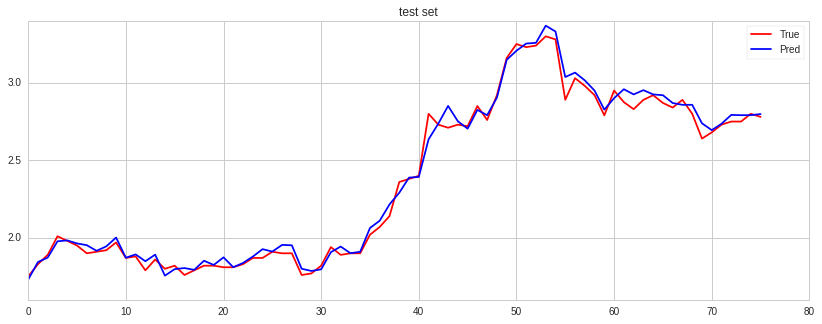

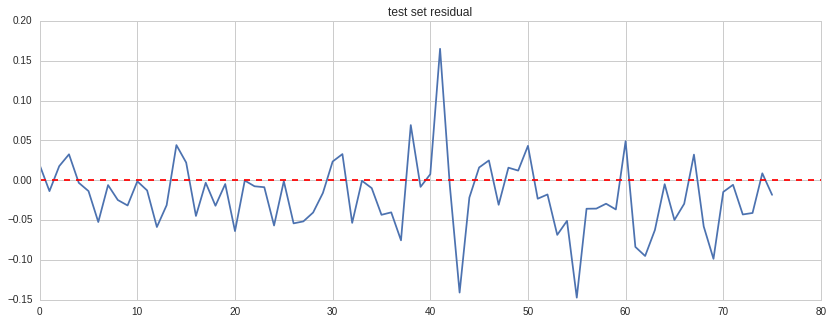

In [37]:
plt.figure(figsize=(14,5))
plt.plot(Y_train.values, c='r', label='True')
plt.plot(Y_train_pred, c='b', label='Pred')
plt.title('train set')
plt.legend()
plt.show()

train_res = Y_train.values.reshape(-1,) - Y_train_pred
plt.figure(figsize=(14,5))
plt.plot(train_res)
plt.axhline(0, ls='--', c='r')
plt.title('train set residual')
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(Y_test.values, c='r', label='True')
plt.plot(Y_test_pred, c='b', label='Pred')
plt.title('test set')
plt.legend()
plt.show()

test_res = Y_test.values.reshape(-1,) - Y_test_pred
plt.figure(figsize=(14,5))
plt.plot(test_res)
plt.axhline(0, ls='--', c='r')
plt.title('test set residual')
plt.legend()
plt.show()

From the metrics of the test set, we can see performance improvement comparied to OLS.

## Define a general analysis function for showing results

In [38]:
def show_result(X, Y):
    result = pd.DataFrame([], columns=['model', 'mse_train', 'mse_test', 'mae_train', 'mae_test', 'rmse_train', 'rmse_test'])
    Ys_result = {}
    def metrics(Y_train, Y_train_pred, Y_test, Y_test_pred):
        mse_train = mean_squared_error(Y_train_pred, Y_train)
        mse_test = mean_squared_error(Y_test_pred, Y_test)
        mae_train = mean_absolute_error(Y_train_pred, Y_train)
        mae_test = mean_absolute_error(Y_test_pred, Y_test)
        return mse_train, mse_test, mae_train, mae_test, np.sqrt(mse_train), np.sqrt(mse_test)
    # ----------------- OLS ---------------------
    l = X.shape[0]
    X_train = X.iloc[0:int(0.7 * l)]
    Y_train = Y.iloc[0:int(0.7 * l)]
    X_test = X.iloc[int(0.7 * l):]
    Y_test = Y.iloc[int(0.7 * l):]
    est = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
    print(est.summary())
    Y_train_pred = est.predict(sm.add_constant(X_train))
    Y_test_pred = est.predict(sm.add_constant(X_test))
    result = result.append(
        pd.Series(['OLS'] + list(metrics(Y_train, Y_train_pred, Y_test, Y_test_pred)), index=result.columns),
        ignore_index=True)
    Ys_result['OLS'] = {}
    Ys_result['OLS']['Y_train'] = Y_train
    Ys_result['OLS']['Y_test'] = Y_test
    Ys_result['OLS']['Y_train_pred'] = Y_train_pred
    Ys_result['OLS']['Y_test_pred'] = Y_test_pred
    # --------------- diff + OLS ----------------
    X_diff = diff(X)
    
    l = X_diff.shape[0]
    X_train = X_diff.iloc[0:int(0.7 * l)]
    Y_train = Y.iloc[0:int(0.7 * l)]
    X_test = X_diff.iloc[int(0.7 * l):]
    Y_test = Y.iloc[int(0.7 * l):]
    est = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
    Y_train_pred = est.predict(sm.add_constant(X_train))
    Y_test_pred = est.predict(sm.add_constant(X_test))
    result = result.append(
        pd.Series(['diff'] + list(metrics(Y_train, Y_train_pred, Y_test, Y_test_pred)), index=result.columns),
        ignore_index=True)
    Ys_result['diff'] = {}
    Ys_result['diff']['Y_train'] = Y_train
    Ys_result['diff']['Y_test'] = Y_test
    Ys_result['diff']['Y_train_pred'] = Y_train_pred
    Ys_result['diff']['Y_test_pred'] = Y_test_pred
    # --------------- LASSO----------------
    las = LassoLarsCV(cv=5).fit(X_train, Y_train.values.reshape(-1,))
    Y_train_pred = las.predict(X_train)
    Y_test_pred = las.predict(X_test)
    result = result.append(
        pd.Series(['LASSO'] + list(metrics(Y_train, Y_train_pred, Y_test, Y_test_pred)), index=result.columns),
        ignore_index=True)
    Ys_result['LASSO'] = {}
    Ys_result['LASSO']['Y_train'] = Y_train
    Ys_result['LASSO']['Y_test'] = Y_test
    Ys_result['LASSO']['Y_train_pred'] = Y_train_pred
    Ys_result['LASSO']['Y_test_pred'] = Y_test_pred
    return result.set_index('model'), Ys_result

def plot(Ys_result, figsize=(12,4)):
    for model in ['OLS', 'diff', 'LASSO']:
        Ys = Ys_result[model]
        Y_train = Ys['Y_train']
        Y_test = Ys['Y_test']
        Y_train_pred = Ys['Y_train_pred']
        Y_test_pred = Ys['Y_test_pred']
        plt.figure(figsize=figsize)
        plt.plot(Y_train.values, c='r', label='True')
        plt.plot(Y_train_pred, c='b', label='Pred')
        plt.title('%s Train Set Prediction' % model)
        plt.legend()
        plt.show()

        train_res = Y_train.values.reshape(-1,) - Y_train_pred
        plt.figure(figsize=figsize)
        plt.plot(train_res)
        plt.axhline(0, ls='--', c='r')
        plt.title('%s Train Set Residual' % model)
        plt.legend()
        plt.show()

        plt.figure(figsize=figsize)
        plt.plot(Y_test.values, c='r', label='True')
        plt.plot(Y_test_pred, c='b', label='Pred')
        plt.title('%s Test Set' % model)
        plt.legend()
        plt.show()

        test_res = Y_test.values.reshape(-1,) - Y_test_pred
        plt.figure(figsize=figsize)
        plt.plot(test_res)
        plt.axhline(0, ls='--', c='r')
        plt.title('%s Test Set Residual' % model)
        plt.legend()
        plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


For equity Equity(43025 [LPCN])
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     206.1
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           2.13e-95
Time:                        20:47:38   Log-Likelihood:                 220.41
No. Observations:                 177   AIC:                            -410.8
Df Residuals:                     162   BIC:                            -363.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
cons

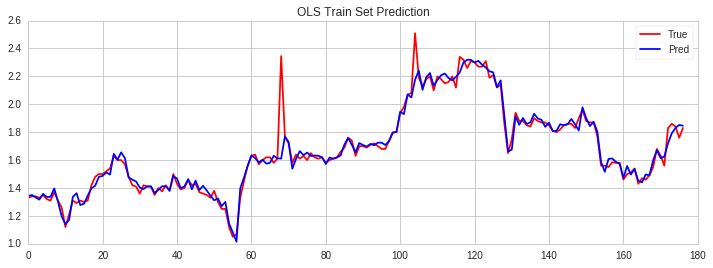

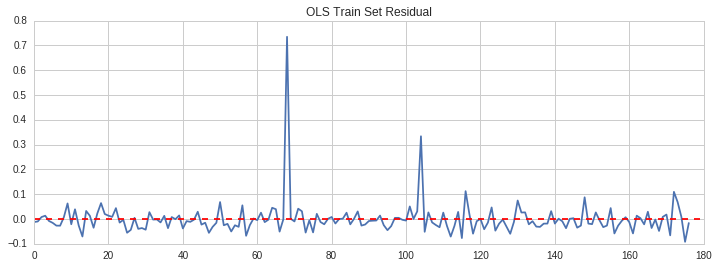

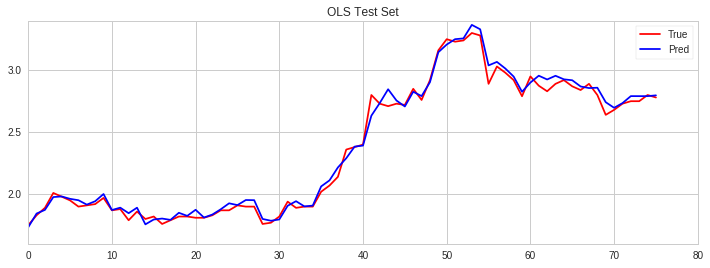

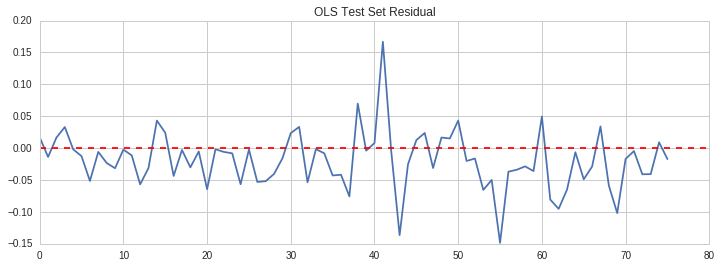

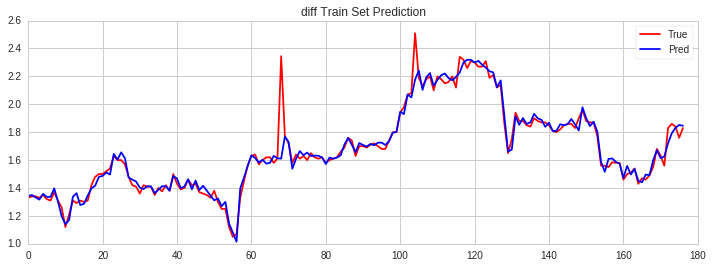

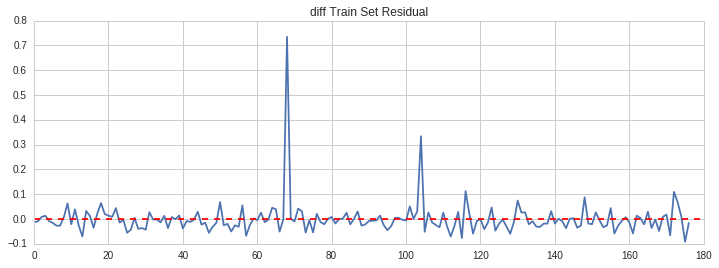

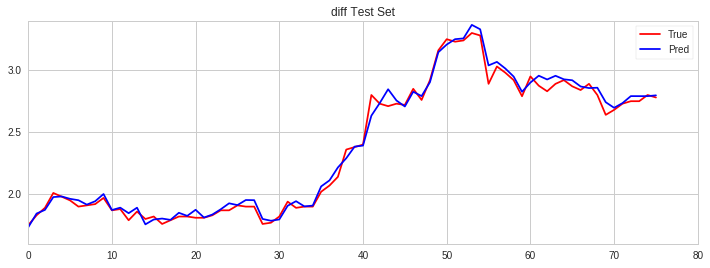

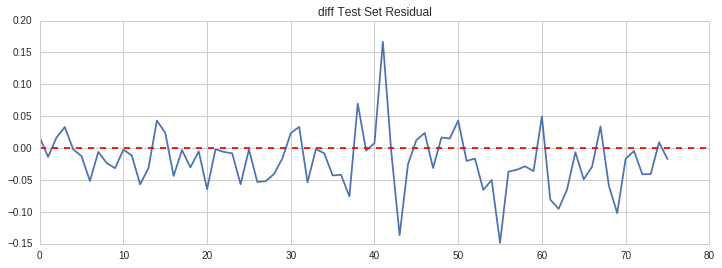

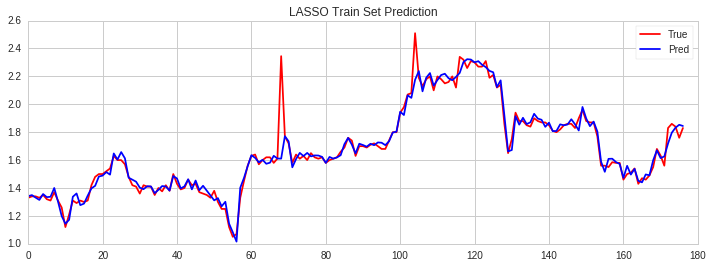

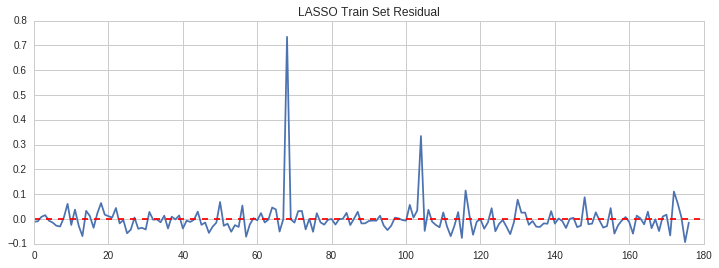

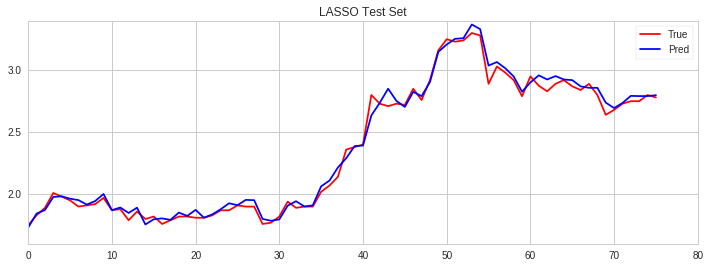

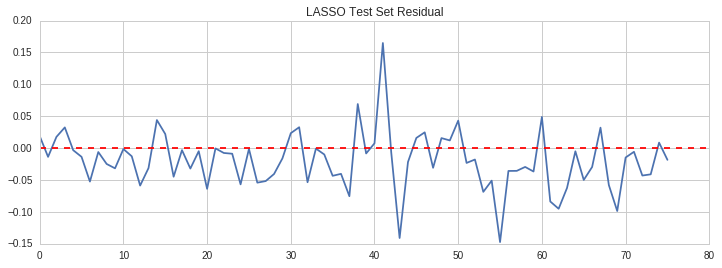

For equity Equity(8732 [SCON])
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     637.3
Date:                Thu, 24 Oct 2019   Prob (F-statistic):          1.01e-133
Time:                        20:47:40   Log-Likelihood:                 305.71
No. Observations:                 177   AIC:                            -581.4
Df Residuals:                     162   BIC:                            -533.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const

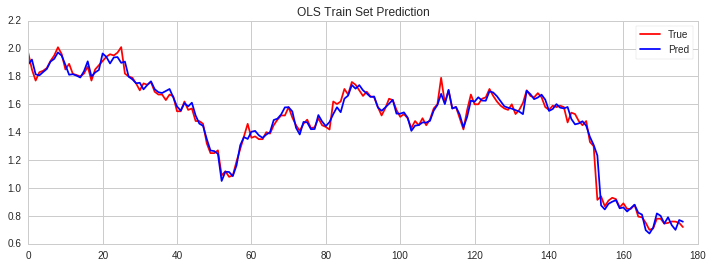

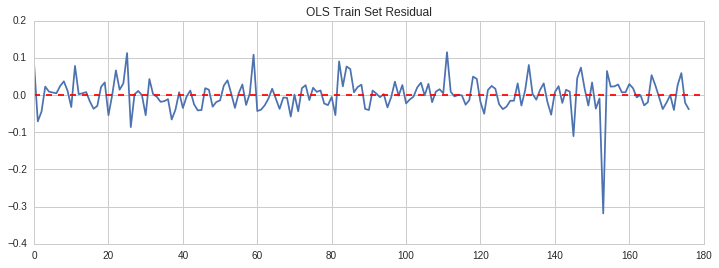

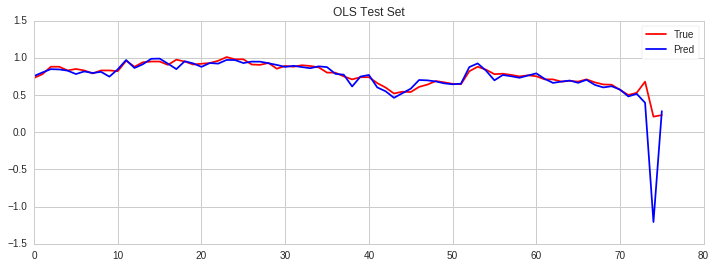

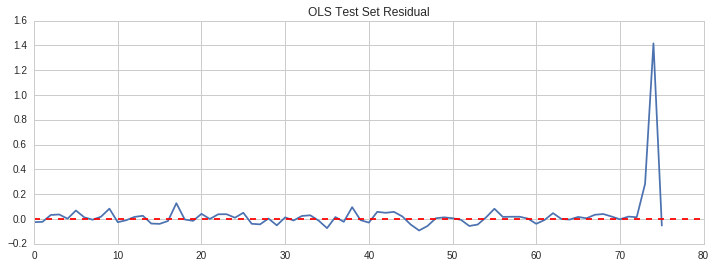

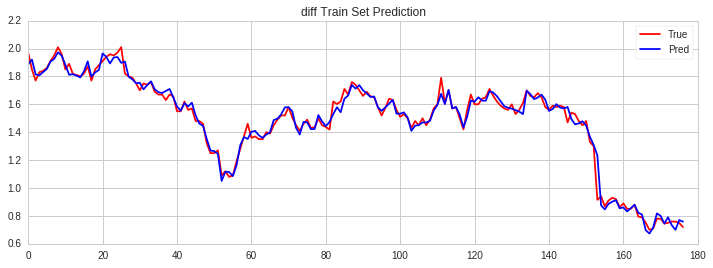

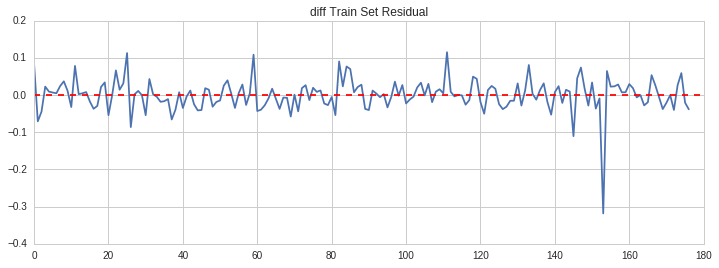

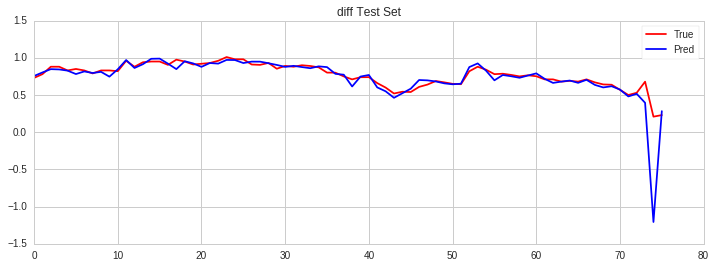

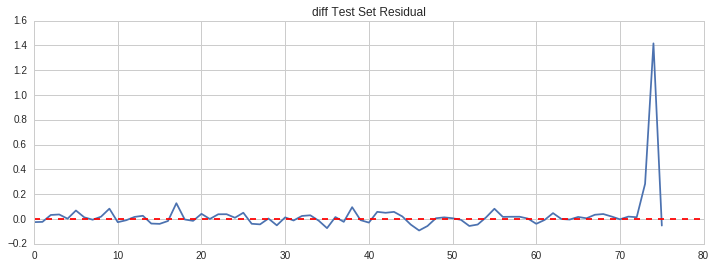

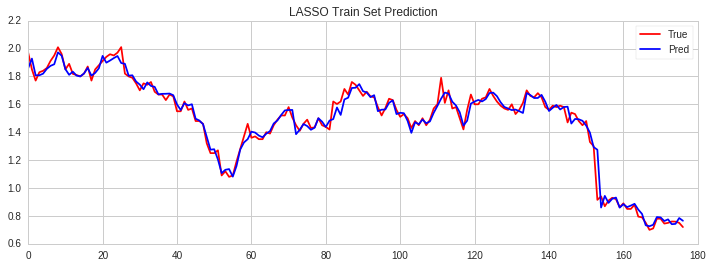

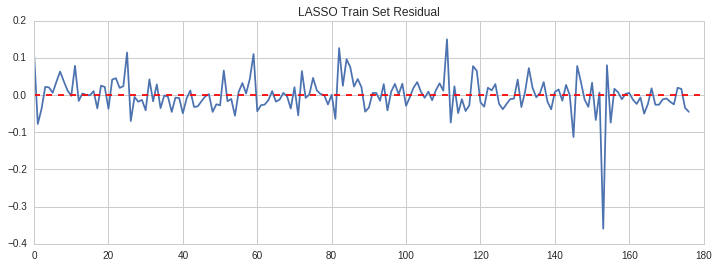

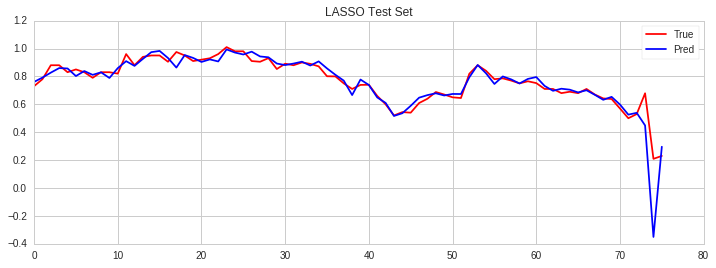

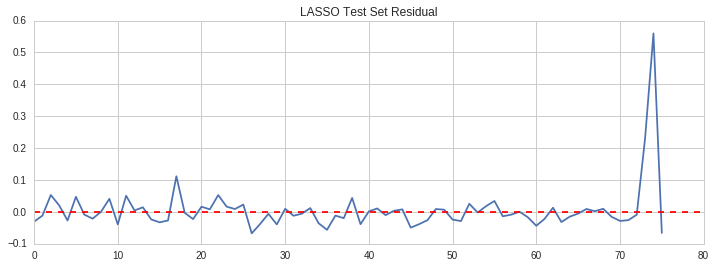

In [39]:
for equity in equities:
    print('For equity %s' % equity)
    X = Xs[equity]
    Y = Ys[equity]
    result, Ys_result = show_result(X, Y)
    print('Metrics are:')
    print(result)
    print('Figures are:')
    plot(Ys_result)


# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 2".
        
**Note: Each team only needs to submit one submission in Canvas**